### Data Collection

Extract the compressed files (xml.tgz and words.tgz)

In [84]:
import tarfile
import os

def extract_files(filename, extract_path):
    # Check if extraction is necessary
    if os.path.exists(extract_path):
        print(f"Files already extracted in {extract_path}. Skipped extraction.")
        return

    # Check if the file is a tar archive
    if filename.endswith('.tar') or filename.endswith('.tgz'):
        with tarfile.open(filename, 'r:*') as tar:
            tar.extractall(extract_path)
            print(f"Extracted {filename} to {extract_path}")
    else:
        print("File is not a tar or tgz archive.")

if __name__ == '__main__':
    # Extract words.tgz
    extract_files('data/words.tgz', 'data/words')

    # Extract xml.tar
    extract_files('data/xml.tar', 'data/xml')

Files already extracted in data/words. Skipped extraction.
Files already extracted in data/xml. Skipped extraction.


Load the information of the xml files to a dataframe (not used)

In [17]:
# import os
# import pandas as pd
# import xml.etree.ElementTree as ET

# # Directory containing XML files
# directory = 'data/xml'

# # Initialize an empty list to hold the word data
# data = []

# # Loop through each file in the directory
# for filename in os.listdir(directory):
#     if filename.endswith('.xml'):
#         # Construct the full file path
#         file_path = os.path.join(directory, filename)
        
#         # Parse the XML
#         tree = ET.parse(file_path)
#         root = tree.getroot()
        
#         # Extract word data
#         for word in root.findall('.//word'):
#             word_id = word.get('id')
#             text = word.get('text')
#             tag = word.get('tag')
#             components = [(int(cmp.get('x')), int(cmp.get('y')), int(cmp.get('width')), int(cmp.get('height'))) for cmp in word.findall('.//cmp')]
            
#             # Append the data to our list
#             data.append([word_id, text, tag, components])

# # Create a DataFrame from the list
# df = pd.DataFrame(data, columns=['WordID', 'Text', 'Tag', 'Components'])

Load the information of the words.txt to a dataframe name df.

Information loaded: 

| Column          | Description                                                     |
|----------------------|-----------------------------------------------------------------|
| `WordID`             | The ID of the word. Corresponds to the name of image files in `data/words`. |
| `SegmentationResult` | Result of word segmentation - `ok`: word was correctly, `er`: segmentation of word can be bad. |
| `GrayLevel`          | Gray level to binarize the line containing the word.            |
| `BoundingBox`        | Bounding box around this word in x,y,w,h format.                |
| `GrammaticalTag`     | The grammatical tag for this word.                              |
| `Transcription`      | The transcription for the word.                                 |


In [85]:
import pandas as pd

# Path to the text file
file_path = 'data/words.txt'

# Initialize an empty list to hold the parsed data
data = []

# Open and read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Skip lines that don't contain the data (like comments)
        if line.startswith('#') or not line.strip():
            continue

        # Split the line into parts
        parts = line.split()

        # Extract the relevant information
        word_id = parts[0]
        segmentation_result = parts[1]
        graylevel = int(parts[2])
        #num_components = int(parts[3])
        bounding_box = tuple(map(int, parts[3:7]))
        grammatical_tag = parts[7]
        transcription = ' '.join(parts[8:])

        # Append the data to the list
        data.append([word_id, segmentation_result, graylevel, bounding_box, grammatical_tag, transcription])

# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['WordID', 'SegmentationResult', 'GrayLevel', 'BoundingBox', 'GrammaticalTag', 'Transcription'])

# Display the first few rows of the DataFrame
df.head()

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription
0,a01-000u-00-00,ok,154,"(408, 768, 27, 51)",AT,A
1,a01-000u-00-01,ok,154,"(507, 766, 213, 48)",NN,MOVE
2,a01-000u-00-02,ok,154,"(796, 764, 70, 50)",TO,to
3,a01-000u-00-03,ok,154,"(919, 757, 166, 78)",VB,stop
4,a01-000u-00-04,ok,154,"(1185, 754, 126, 61)",NPT,Mr.


Functions to load and preprocess the images of the words.

The `load_image` function takes a file path as input and loads an image in grayscale mode using the OpenCV library. It returns the loaded image.

The `preprocess_image` function takes an image as input does the following: 
1. Resizes the image to a target size using the OpenCV `resize` function. 
2. Normalizes the pixel values of the image by dividing them by 255 - pixels range from 0 to 255 (colour), this division scales the pixels to a range of 0 to 1.
3. Adds a channel dimension to the image to make it compatible with deep learning models that expect input in the form of `[height, width, channels]`. 
4. The preprocessed image is then returned.

In [86]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

def load_image(file_path):
    # Load an image in grayscale mode
    return cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)

def preprocess_image(image, target_size=(128, 32)):
    """
    Preprocesses an image by resizing it to the target size, normalizing it, and adding a channel dimension.

    Parameters:
    - image: The input image to be preprocessed.
    - target_size: The desired size of the image after resizing. Default is (128, 32).

    Returns:
    - The preprocessed image.
    """
    # Resize the image to the target size
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Normalize the image
    image = image.astype(np.float32) / 255.0
    
    # Add a channel dimension ([height, width] -> [height, width, 1])
    image = np.expand_dims(image, axis=-1)
    
    return image

Having defined the load and preprocess image functions, the image data (pixel matrices) will be loaded into a new column of the previously created dataframe.

1. **Prepare DataFrame**: Prepare a column named `ImageData` in the DataFrame `df` to store image data (image matrix).
2. **Set Base Directory**: Define the base directory where the word images are stored - data/words.
3. **Iterate Through Directories**: Iterate through all the subdirectories and files in the base directory.
4. **For Each .png File**:

    a. **Extract WordID**: Remove the `.png` extension to get the WordID (WordID = filename minus extension)

    b. **Check Presence**: Verify if the WordID is in the 'WordID' column of the DataFrame.

    c. **Process Image** (if WordID is present):

        - Construct the path.
        - Load and preprocess the image.
        - Find the index in the DataFrame for the WordID.
        - Assign the preprocessed image data (matrix) to the corresponding row.
        - Update the count and display progress.

    d. **Error Handling**: Print an error message if there's an exception.

In [95]:
from IPython.display import clear_output
import time

# Prepare a column named ImageData in the DataFrame df to store image data (image matrix)
df['ImageData'] = None  # Prepare a column for the image data

# Define the base directory where the word images are stored
base_dir = Path('data/words')

count = 0
start_time = time.time()
# Loop through all the subdirectories and files in the base directory
for subdir, _, files in os.walk(base_dir):
    for file_name in files:
        if file_name.endswith('.png'):
            # Extract the WordID from the file name (assuming it matches the WordID format)
            word_id = file_name[:-4]  # Remove the '.png' extension
            
            # Check if this WordID is in the DataFrame
            if word_id in df['WordID'].values:
                img_path = Path(subdir) / file_name
                
                try:
                    # Load and preprocess the image
                    img = load_image(img_path)
                    img = preprocess_image(img)
                    
                    # Find the index in the DataFrame where this WordID is located
                    idx = df.index[df['WordID'] == word_id].tolist()[0]
                    
                    # Assign the preprocessed image to the correct row in the DataFrame
                    df.at[idx, 'ImageData'] = img

                    count += 1
                    print(f"Processed {count} images.", end='\r')
                    clear_output(wait=True)
                    
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # if count >= 1000:
    #     print("elapsed time (seconds):", time.time() - start_time)
    #     print(f"Processed {count} images.", end='\r')
    #     break

In [103]:
# save the daframe to csv and pickle
df.to_csv('data/words_df.csv')
df.to_pickle('data/words_df.pkl')

In [88]:
images = df[~df['ImageData'].isnull()]

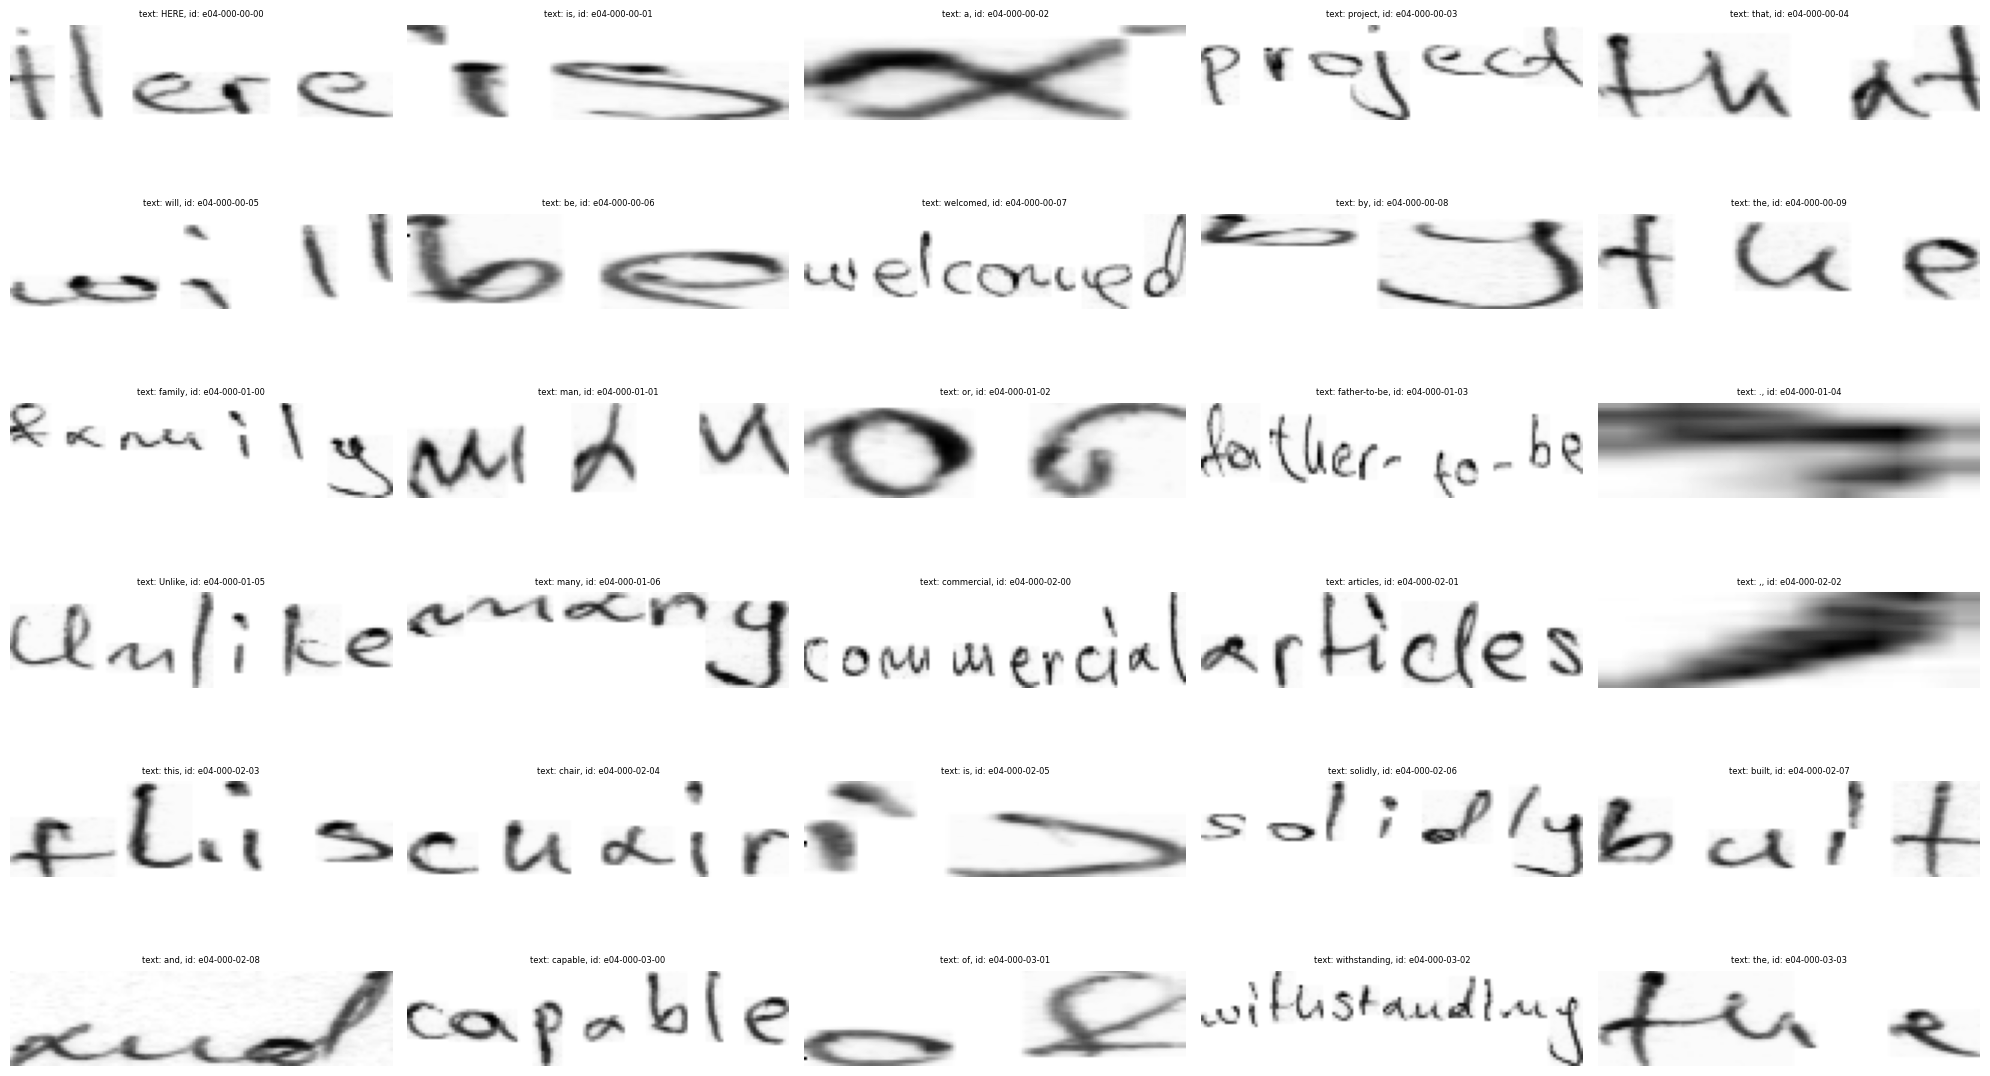

In [89]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(dataframe, num_images=100):
    # Calculate the number of rows and columns (you might want to tweak these values)
    cols = 5  # for example, 10 images per row
    rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))  # Adjust the size as needed

    for i in range(num_images):
        if i >= len(dataframe):
            break  # Break if there are no more images to display

        # Convert 1D array of axes to 2D for easier indexing
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]

        # Get the image data from the DataFrame
        img_data = dataframe.iloc[i]['ImageData']
        
        if img_data is not None:
            img = np.squeeze(img_data)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"text: {dataframe.iloc[i]['Transcription']}, id: {dataframe.iloc[i]['WordID']}", fontsize=6)
        else:
            ax.set_title("No image data", fontsize=6)

        ax.axis('off')  # Turn off axis numbers and ticks

    # Hide any unused subplots
    for i in range(num_images, rows * cols):
        axes.flatten()[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
display_images(images, num_images=30)  # Adjust num_images as needed

Creation of a txt file to save the paths of all the images

In [90]:
import os
from pathlib import Path

def export_image_paths(base_dir, output_file):
    base_path = Path(base_dir)
    with open(output_file, 'w') as file:
        # Walk through the directory
        for subdir, _, files in os.walk(base_path):
            for filename in files:
                # Check if the file is a .png
                if filename.endswith('.png'):
                    # Construct the full path
                    full_path = Path(subdir) / filename
                    # Write the path to the file
                    file.write(str(full_path) + '\n')

# Set your base directory and output file name
base_directory = 'data/words'
output_txt_file = 'data/img_paths.txt'

# Call the function with your specified paths
export_image_paths(base_directory, output_txt_file)

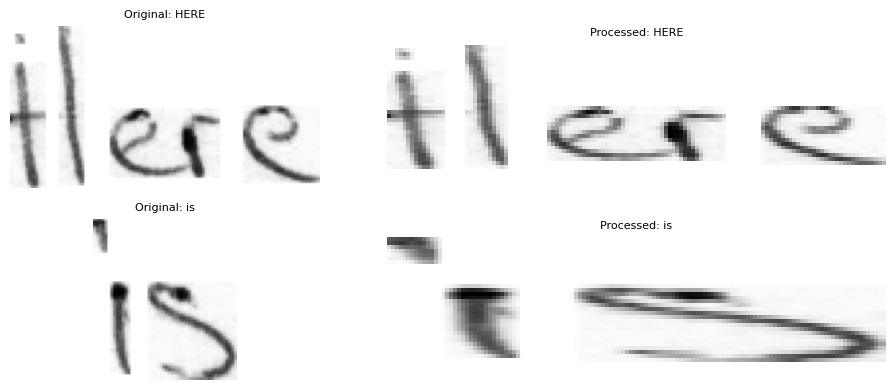

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

def load_original_image(file_path):
    return cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)

def read_image_paths(file_path):
    with open(file_path, 'r') as file:
        return {Path(line.strip()).stem: line.strip() for line in file}

def display_images_side_by_side(dataframe, img_paths_file='img_paths.txt', num_pairs=10):
    # Load image paths from the file
    img_paths = read_image_paths(img_paths_file)
    
    # Calculate rows needed (one row per pair)
    rows = num_pairs

    fig, axes = plt.subplots(rows, 2, figsize=(10, 2 * rows))  # 2 columns for original and processed

    for i in range(num_pairs):
        if i >= len(dataframe):
            break  # Break if there are no more images to display

        word_id = dataframe.iloc[i]['WordID']
        text = dataframe.iloc[i]['Transcription']

        # Use the path from the img_paths dictionary
        original_img_path = img_paths.get(word_id)

        # Define axes for original and processed images
        ax_original = axes[i, 0] if rows > 1 else axes[0]
        ax_processed = axes[i, 1] if rows > 1 else axes[1]

        # Show original image
        if original_img_path:
            original_img = load_original_image(original_img_path)
            if original_img is not None:
                ax_original.imshow(original_img, cmap='gray')
                ax_original.set_title(f"Original: {text}", fontsize=8)
            else:
                ax_original.set_title("Original image not found", fontsize=8)
        else:
            ax_original.set_title("Path not found in img_paths.txt", fontsize=8)
        ax_original.axis('off')

        # Show processed image
        processed_img_data = dataframe.iloc[i]['ImageData']
        if processed_img_data is not None:
            processed_img = np.squeeze(processed_img_data)
            ax_processed.imshow(processed_img, cmap='gray')
            ax_processed.set_title(f"Processed: {text}", fontsize=8)
        else:
            ax_processed.set_title("Processed image data not available", fontsize=8)
        ax_processed.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame and the text file containing image paths
display_images_side_by_side(images, img_paths_file='data/img_paths.txt', num_pairs=2)  # Adjust num_pairs as needed

In [67]:
images.head()

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
40906,e04-000-00-00,ok,187,"(361, 767, 121, 63)",RN,HERE,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."
40907,e04-000-00-01,ok,187,"(560, 777, 50, 56)",BEZ,is,"[[[0.4745098], [0.45490196], [0.43137255], [0...."
40908,e04-000-00-02,ok,187,"(694, 801, 25, 27)",AT,a,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."
40909,e04-000-00-03,ok,187,"(770, 782, 196, 84)",NN,project,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."
40910,e04-000-00-04,ok,187,"(1024, 786, 115, 44)",WP,that,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."


Export an image matrix to a txt file

In [92]:
# Convert the 3D image data to a 2D array by removing the single-channel dimension
image_2d = np.squeeze(images.iloc[2]['ImageData'])

# Export the 2D array to a text file
with open('image_matrix.txt', 'w') as f:
    for row in image_2d:
        f.write(' '.join([str(pixel) for pixel in row]) + '\n')


### Modelling

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))

# Evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [93]:
df['SegmentationResult'].value_counts()

SegmentationResult
ok     96456
err    18864
Name: count, dtype: int64